# Pre-Processing of Data
In this notebook, the chords from the dataset [iRealPro Corpus of Jazz Standards](https://zenodo.org/record/3546040#.Y3dospDMJeD) will be **extraced, arranged** and **simplified**.

In [1]:
import os, glob, random
from functions.utils import extract_chords, flatten_chords

from functions.ChordSimplifier import ChordSimplifier
from functions.utils import visualize_chord_simplification

## Open all Files
1. Save it in the variable `all_chords`.
2. Flatten the Data.

In [2]:
def get_jazz_files(directory):
    jazz_files = []
    for file_path in glob.glob(os.path.join(directory, "*.jazz")):
        jazz_files.append(file_path)
    return jazz_files

jazz_files = get_jazz_files("data")

Lets look at a datapoint before we flatten it and after:

In [3]:
with open ("data/conferenceofthebirds.jazz", "r") as fh:
    text = fh.read()

extracted = extract_chords(text)
print(extracted)
arranged = flatten_chords(extracted) 
print(arranged)

['2.D:min', '2F', '2.B-', '2E-', '2.D:min', '2F', '2.B-', '2E-']
['D:min', 'D:min', 'D:min', 'F', 'F', 'B-', 'B-', 'B-', 'E-', 'E-', 'D:min', 'D:min', 'D:min', 'F', 'F', 'B-', 'B-', 'B-', 'E-', 'E-']


## Note lenghts
Lets look at the note lenghts. Is there notes shorter than a fourth (1/4)? any other special cases?

In [4]:
durations = {}
for file in jazz_files:
    with open(file, "r") as fh:
        text = fh.read()
    
    chords = extract_chords(text)
    for chord in chords:
        if len(chord) == 1:
            continue
            
        if chord [1] == ".":
            duration = chord[:2]
        else:
            duration = chord[0]

        if duration not in durations.keys():
            durations[duration] = 1
        else:
            durations[duration] += 1  

durations

{'1': 23967, '2': 29572, '4': 2503, '2.': 3492, '4.': 454, '1.': 102, '8': 30}

We have the follwoing durations:
`{'1': 23967, '2': 29572, '4': 2503, '2.': 3492, '4.': 454, '1.': 102, '8': 30}`

Observe that we have just a bit eight notes (8). They will be converted to fourth, becuse otherwise we have to change the sequcne rythm we feed into the network from 1/4 per sequnce to 1/8 per sequnce - which would double the seunce lenght and then skew the predictions from one chord to the same often times, which is not desired. Since we also have the same problem with the `4.` note since its a sixth (1/6), we will also prune this to a fouth (1/4).

The follwoing rules will now hold:
- Each timestep of the RNN will be 1/4 Bar.
- `8` (eight) be converted to a 1/4
- `4.` (fourth dotted) will be converted to 1/4

### Time signatures
How are the time signatures distributed?

In [5]:
from functions.utils import extract_signature
time_signatures = {}

for file in jazz_files:
    with open(file, "r") as fh:
        text = fh.read()

    time = extract_signature(text)
        
    if time not in time_signatures.keys():
        time_signatures[time] = 1
    else:
        time_signatures[time] += 1

time_signatures

{'4/4': 1099, '3/4': 79, '6/4': 3, '5/4': 3, '3/2': 1, '6/8': 1}

### Get all chords
Open all the files in the directory, then save it to a variable `all_chords`.

In [6]:
all_chords = []
for file in jazz_files:
    with open(file, "r") as fh:
        text = fh.read()

    extracted = extract_chords(text)
    arranged = flatten_chords(extracted) 
    all_chords.append(arranged)

### Counting (before simplification)
Count how many distinct chords occur in the dataset.

In [14]:
def count_chords(list_2d):
    # Initialize an empty dictionary to store the counts
    count_dict = {}
    
    # Loop through each sublist in the 2D list
    for sublist in list_2d:
        # Loop through each string in the sublist
        for string in sublist:
            # Increment the count in the dictionary
            count_dict[string] = count_dict.get(string, 0) + 1

    sorted_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))
    return sorted_dict


counter_before = count_chords(all_chords)
for key, value in counter_before.items():
        #print(f"'{key}': {value}")
        pass
print(len(counter_before.keys()))
for k, v in counter_before.items():
    #print(k, v) 
    pass

1006


### Counting (after simplification)
Now we will simplify the Chords. We use the class `ChordSimplifier` from `functions/ChordSimplifier.py`. The simplified chords will be saved into a new list, called `simplified_chords`. They still contain the `Invalid/No Chord` element in the sequence. This is important for later, when we do filtering.

In [17]:
simplifier = ChordSimplifier()

simplified_chords = []
for chord_list in all_chords:
    simplified_chords.append(simplifier.batch_simplify_chord(chord_list))

counter_simplified_chords = count_chords(simplified)
print("Now we have a vocab of: ", len(counter_simplified_chords))

Now we have a vocab of:  86


### Chord Simplifiyng
Visualize how we simplify

In [13]:
chord_vocab = counter_before.keys()

print(len(simplified))
sample_visualization = visualize_chord_simplification(chord_vocab, ChordSimplifier)
print(sample_visualization)  # Displaying the first 1000 characters for a snapshot

1186
Simplified Chord   | Complicated Chords
--------------------------------------------
G:min7             | G:min7, G:min7/F, G:min7/C, G:min7/B-, G:min7/D, G:min7b5, Gmin7
--------------------------------------------
C:7                | C7, C7b9, Ch7, C7sus, C7#9, C7#5, C7#11, C7b13, Co7, C7#9#5, C7/E, C7alt
                   | C7/B-, C7b5/G-, C7/G, C7b9#11, C7b5, C7b9b5, C7b9#5, C7#9b5, Ch7/F
                   | Ch7/G-, Ch7/E-, C7b9sus, Co7/G, C7b9/E, Co7/A, C7b13/E, C7b9/G-, C7;
                   | C7/F, C7/D
--------------------------------------------
B-:7               | B-7, B-7sus, B-7b9, B-7#11, B-7#5, B-o7, B-7b13, B-7#9, B-7#9#5, B-7/D
                   | B-7alt, B-h7, B-7b13sus, B-7/A-, B-7/F, B-7b9sus, B-7b5, B-7u, B-7b9#11
                   | B-o7/F, B-7b9b5, B-7b9b13, B-h7/A-, B-7b9/F, B-7b9#5, B-*7+*, B-7b9/E-
                   | B-:7sus, B-:7
--------------------------------------------
G:7                | G7, G7b9, Gh7, G7#5, G7sus, G7b13, G7#11, G7#9, G7b9

### LaTeX visualisation for the thesis
For the appendix, we will generate this visualization of all chord simplifications.

In [38]:
def visualize_chord_simplification_latex(chords):
    # Use the ChordSimplifier class to simplify each chord in the chord_vocab, and give us a longtable
    simplified_chords = {}
    for chord in chords:
        simplified = simplifier.simplify_chord(chord)
        if simplified not in simplified_chords:
            simplified_chords[simplified] = []
        simplified_chords[simplified].append(chord)

    # Generate the LaTeX longtable
    latex_table = []
    latex_table.append("\\begin{longtable}{|l|p{10cm}|}")
    latex_table.append("\\caption{Chord Simplification Visualization} \\\\")
    latex_table.append("\\hline")
    latex_table.append("Simplified Chord & Complicated Chords \\\\ \\hline")
    latex_table.append("\\endhead")  # This will ensure that the column titles repeat on each page

    for simple_chord, complicated_chords in simplified_chords.items():
        comp_chords_str = ', '.join(complicated_chords).replace('#', '\\#').replace('^', '\\^')
        simple_chord = simple_chord.replace('#', '\\#').replace('^', '\\^')
        latex_table.append(f"{simple_chord} & {comp_chords_str} \\\\ \\hline")

    latex_table.append("\\end{longtable}")

    return '\n'.join(latex_table)

# Let's test the function with a sample from the chord_vocab
sample_latex_visualization = visualize_chord_simplification_latex(list(counter_before.keys())[:]) 
print(sample_latex_visualization)  # Displaying the LaTeX code for the longtable

\begin{longtable}{|l|p{10cm}|}
\caption{Chord Simplification Visualization} \\
\hline
Simplified Chord & Complicated Chords \\ \hline
\endhead
G:min7 & G:min7, G:min7/F, G:min7/C, G:min7/B-, G:min7/D, G:min7b5, Gmin7 \\ \hline
C:7 & C7, C7b9, Ch7, C7sus, C7\#9, C7\#5, C7\#11, C7b13, Co7, C7\#9\#5, C7/E, C7alt, C7/B-, C7b5/G-, C7/G, C7b9\#11, C7b5, C7b9b5, C7b9\#5, C7\#9b5, Ch7/F, Ch7/G-, Ch7/E-, C7b9sus, Co7/G, C7b9/E, Co7/A, C7b13/E, C7b9/G-, C7;, C7/F, C7/D \\ \hline
B-:7 & B-7, B-7sus, B-7b9, B-7\#11, B-7\#5, B-o7, B-7b13, B-7\#9, B-7\#9\#5, B-7/D, B-7alt, B-h7, B-7b13sus, B-7/A-, B-7/F, B-7b9sus, B-7b5, B-7u, B-7b9\#11, B-o7/F, B-7b9b5, B-7b9b13, B-h7/A-, B-7b9/F, B-7b9\#5, B-*7+*, B-7b9/E-, B-:7sus, B-:7 \\ \hline
G:7 & G7, G7b9, Gh7, G7\#5, G7sus, G7b13, G7\#11, G7\#9, G7b9sus, G7/B, G7b5, G7alt, Go7, G7/D, G7/F, G7b9b13, G7b9\#5, Gh7/C, Gh7/D-, G7\#9\#5, G7b9/F, G7b9\#11, G7b13/B, Go7/F, G7b9b5, G*7+*, G7b9/C, G7b9/B \\ \hline
D:min7 & D:min7, D:min7/C, D:min7/G, D:min7/F, D:min

### Chord Filtering
Still, we have two properties that we want to avoid:

1. Some songs are just one chord repeating, with musical notes. When we remove musical notes, we only have the chord progression left which is not desired (since our network will overlearn this).
2. Somce songs have a lot of invalid elemnts. We will define a threshold when we cut them out of our dataset.

In [30]:
def filter_songs(songs, repetition_threshold=0.5, invalid_threshold=0.3):
    """
    Filters out songs based on repetition and invalid chord thresholds.
    
    Parameters:
    - songs: List of songs, where each song is a list of chords.
    - repetition_threshold: Fraction of most repeated chord to total chords in a song. Default is 0.5.
    - invalid_threshold: Fraction of "Invalid/No Chord" to total chords in a song. Default is 0.1.

    Returns:
    - A list of filtered songs.
    """
    filtered_songs = []
    invalid_songs = []
    
    for song in songs:
        chord_counts = {}
        total_chords = len(song)
        
        for chord in song:
            if chord not in chord_counts:
                chord_counts[chord] = 0
            chord_counts[chord] += 1
        
        # Identify the most repeated chord
        most_repeated_chord = max(chord_counts, key=chord_counts.get)
        
        # Check the repetition threshold
        if chord_counts[most_repeated_chord] / total_chords > repetition_threshold:
            invalid_songs.append(song)
            continue
        
        # Check the invalid chord threshold
        if "Invalid/No Chord" in chord_counts and chord_counts["Invalid/No Chord"] / total_chords > invalid_threshold:
            invalid_songs.append(song)
            continue
        
        filtered_songs.append(song)
    
    return filtered_songs, invalid_songs

filtered_songs, invalid_songs = filter_songs(simplified_chords)
print("Old elements: ", len(simplified_chords))
print("New elements: ", len(filtered_songs))
for song in invalid_songs:
    print(song)
    print("----------------")

Old elements:  1186
New elements:  1123
['D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'D:min', 'G:min7', 'G:min7', 'G:min7', 'G:min7', 'G:min7', 'G:min7', 'G:min7', 'G:min7', 'B-:min7', 'B-:min7', 'B-:min7', 'B-:min7', 'E-:7', 'E-:7', 'E-:7', 'E-:7', 'A:min7', 'A:min7', 'A:min7', 'A:min7', 'A:min7', 'A:min7', 'D:7', 'D:7', 'G', 'G', 'A:min7', 'A:min7', 'B-', 'B-', 'B:min7', 'B:min7']
----------------
['A-:min', 'A-:min', 'A-:min', 'A-:min', 'A-:min', 'A-:min', 'A-:min', 'A-:min', 'A-:min', 'A-:min', 'A-:min', 'A-:min', 'A-:min', 'A-:min', 'A-:m

### Cut out Invalid
Fiinally, we will just remove the invalid tokens from the sequnce. 

In [33]:
def remove_invalid_tokens(filtered_songs):
    """
    Removes the "Invalid/No Chord" tokens from each song in the filtered songs list.
    
    Parameters:
    - filtered_songs: List of songs, where each song is a list of chords.
    
    Returns:
    - A list of songs with the "Invalid/No Chord" tokens removed.
    """
    
    cleaned_songs = []
    
    for song in filtered_songs:
        cleaned_song = [chord for chord in song if chord != "Invalid/No Chord"]
        cleaned_songs.append(cleaned_song)
    
    return cleaned_songs

final_songs = remove_invalid_tokens(filtered_songs)
for song in final_songs:
    print(song)
    print("----------------")

['B-:min', 'B-:min', 'B-:min', 'B-:min', 'D:7', 'D:7', 'D:7', 'D:7', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'B-:min', 'B-:min', 'B-:min', 'B-:min', 'D:7', 'D:7', 'D:7', 'D:7', 'G', 'G', 'D:7', 'D:7', 'G', 'G', 'G', 'G', 'B:7', 'B:7', 'B:7', 'B:7', 'B:7', 'B:7', 'B:7', 'B:7', 'E:min', 'E:min', 'E:min', 'E:min', 'E:min', 'E:min', 'E:min', 'E:min', 'A:7', 'A:7', 'A-:7', 'A-:7', 'A:7', 'A:7', 'A:7', 'A:7', 'D:7', 'D:7', 'D:7', 'D:7', 'D:7', 'D:7', 'D:7', 'D:7', 'B-:min', 'B-:min', 'B-:min', 'B-:min', 'D:7', 'D:7', 'D:7', 'D:7', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'A-:7', 'A-:7', 'A-:7', 'A-:7', 'G:7', 'G:7', 'G:7', 'G:7', 'C:min', 'C:min', 'C:min', 'C:min', 'C:min', 'C:min', 'C:min', 'C:min', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'G', 'B-:min', 'B-:min', 'B-:min', 'B-:min', 'D:7', 'D:7', 'D:7', 'D:7', 'G', 'G', 'D:7', 'D:7', 'G', 'G', 'G', 'G']
----------------
['A:7', 'A:7', 'D:7', 'D:7', 'G:min7', 'G:min7', 'C:7', 'C:7', 'B:maj7', 'B:maj7', 'F:7', 'B-:maj7', 'B-:maj7', 'B-:maj7', 'B-:m

## Chord Statistics
Now lets look at some stats from the chords - how are they distributed?

### Musical Piece lenghs
How are the lenghts of our pices?

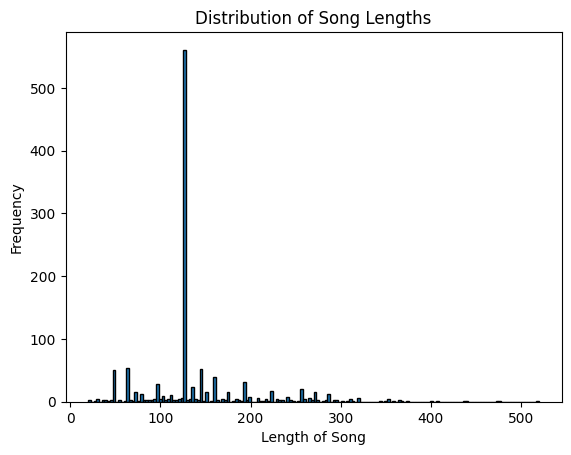

142.6450252951096

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Calculate lengths of the inner lists
lengths = [len(lst) for lst in all_chords]

# Plot histogram
plt.hist(lengths, bins='auto', edgecolor='black')
plt.title('Distribution of Song Lengths')
plt.xlabel('Length of Song')
plt.ylabel('Frequency')
plt.show()
#plt.savefig('foo.png')

np.mean(lengths)

### Chord Counts
Now lets look at some simple Counts from all chords. 

In [ ]:


# Assuming your 2D list is named chords
# Flattening the list
flat_list = [item for sublist in all_chords for item in sublist]

# Transforming the list into a DataFrame
df = pd.DataFrame(flat_list, columns=['Chord'])

# Counting the occurrences of each chord
chord_counts = df['Chord'].value_counts()
print(df.to_sting())

### Chords: Maj vs Min

In [ ]:
# Counting the occurrences of "maj" and "min"
maj_min_counts = df['Chord'].apply(lambda x: 'maj' if 'maj' in x else 'min').value_counts()

# Creating a pie chart
fig, ax = plt.subplots()
ax.pie(maj_min_counts.values, labels=maj_min_counts.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.title('Major vs Minor Chords')
plt.show()


In [ ]:
from collections import Counter
from operator import itemgetter

# Initialize a Counter object
transitions = Counter()

# Iterate over all songs (represented as lists of chords)
for song in all_chords:
    # Create pairs of subsequent chords
    pairs = zip(song, song[1:])
    # Increment the count for each pair
    for pair in pairs:
        transitions[pair] += 1

# Extract the 10 most common transitions
top_transitions = transitions.most_common(10)

# Separate pairs and counts for plotting
pairs, counts = zip(*top_transitions)

# Convert pairs of chords to string labels
labels = [f"{pair[0]} -> {pair[1]}" for pair in pairs]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(labels, counts, color='steelblue')
plt.xlabel('Count')
plt.title('Top 10 Chord Transitions (2 chords)')
plt.gca().invert_yaxis()  # Reverse the order of labels to have the most common transition on top
plt.savefig("img/top10transitions-2.png")
plt.show()


In [ ]:
from collections import Counter
from operator import itemgetter

# Initialize a Counter object
transitions = Counter()

# Iterate over all songs (represented as lists of chords)
for song in all_chords:
    # Create 4-tuples of subsequent chords
    tuples = zip(song, song[1:], song[2:], song[3:])
    # Increment the count for each tuple
    for t in tuples:
        transitions[t] += 1

# Extract the 10 most common transitions
top_transitions = transitions.most_common(10)

# Separate tuples and counts for plotting
tuples, counts = zip(*top_transitions)

# Convert tuples of chords to string labels
labels = [' -> '.join(t) for t in tuples]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(labels, counts, color='steelblue')
plt.xlabel('Count')
plt.title('Top 10 Chord Progressions')
plt.gca().invert_yaxis()  # Reverse the order of labels to have the most common transition on top
plt.show()

# n gram 

### Chord Transitions Heatmap


In [ ]:
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Counting the transitions between chords
transitions = Counter()

for sublist in all_chords:
    for i in range(len(sublist) - 1):
        transitions[(sublist[i], sublist[i + 1])] += 1

# Create a DataFrame from the transitions
df_transitions = pd.DataFrame.from_records(list(transitions.items()), columns=['Transitions', 'Count'])

# Unpack Transitions column into separate columns for Chord1 and Chord2
df_transitions[['Chord1', 'Chord2']] = pd.DataFrame(df_transitions['Transitions'].tolist(), index=df_transitions.index)

# Drop the old 'Transitions' column
df_transitions.drop(columns=['Transitions'], inplace=True)

# Pivot the DataFrame to create a matrix for the heatmap
df_pivot = df_transitions.pivot(index='Chord1', columns='Chord2', values='Count')

# Replace NaNs with zeros
df_pivot.fillna(0, inplace=True)

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_pivot, cmap="viridis")
plt.title('Chord Transitions')
plt.xlabel('To Chord')
plt.ylabel('From Chord')
plt.show()


# Chord Saving
Save chords to file `chords.data` in a json like format.

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
import json

# first, add start and end tokens to the sequnces
def add_tokens(lists):
    # in case already added 
    if lists[0][0] == "<BOS>":
        return lists
    for i in range(len(lists)):            
        # Add "<BOS>" (beginning of sequnce) at the start of the list
        lists[i].insert(0, "<BOS>")
        # Add "<EOS>" (end of sequcne) at the end of the list
        lists[i].append("<EOS>")
    return lists

all_chords = add_tokens(all_chords)

def save_to_json(data, filename="data.json"):
    with open(filename, 'w') as f:
        json.dump(data, f, indent=4)
        
save_to_json(all_chords, "chords.data")

# Encoded Chord saving

In [ ]:
from functions.utils import encode_chords

chord_vocab, chord_to_idx, idx_to_chord, padded_sequences, vocab_size = encode_chords(all_chords)

print(padded_sequences)